## Visualizing IRIS netcdf tomography models


1. [Volume Rendering](#Volume-Rendering)
2. [Fixed Depth Maps](#Fixed-Depth-Maps)

### Volume Rendering 


The volume rendering here is based on the interactive Binder notebook at the EarthCube 2020, available at the following link: https://github.com/earthcube2020/ec20_havlin_etal and requires the https://github.com/chrishavlin/yt_velmodel_vis repository. For brevity, any of the functions defined in the EarthCube notebook are moved to the `seismic_helper` module in the `resources` directory for the present notebook. See the EarthCube notebook for a detailed explanation.  

In [1]:
# imports and initialization
import os
import yt
import matplotlib.pyplot as plt
from yt_velmodel_vis import seis_model as SM, transferfunctions as TFs
from resources import seismic_helper as SH 

# load interpolated data using the yt uniform grid loader (not editable)
# set the model file and the field to visualize
modelfile='NWUS11-S_percent.nc' # the model netCDF file 
datafld='dvs' # the field to visualize, must be a variable in the netCDF file

# set the interpolation dictionary. If the interpolation for this model does 
# not exist, SM.netcdf() will build it. 
interp_dict={'field':datafld,'max_dist':50000,'res':[10000,10000,10000],
              'input_units':'m','interpChunk':int(1e7)}

# load the model 
model=SM.netcdf(modelfile,interp_dict)

# set some objects required for loading in yt 
bbox = model.cart['bbox'] # the bounding box of interpolated cartesian grid
data={datafld:model.interp['data'][datafld]} # data container for yt scene

# load the data as a uniform grid, create the 3d scene
ds = yt.load_uniform_grid(data,data[datafld].shape,1.0,bbox=bbox,nprocs=1,
                        periodicity=(True,True,True),unit_system="mks")

yt : [INFO     ] 2020-11-18 12:44:52,010 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-18 12:44:52,011 Parameters: domain_dimensions         = [287 271 237]
yt : [INFO     ] 2020-11-18 12:44:52,011 Parameters: domain_left_edge          = [-5201282.   -3445670.25  2740212.5 ]
yt : [INFO     ] 2020-11-18 12:44:52,012 Parameters: domain_right_edge         = [-2328344.5     -735306.5625  5113796.5   ]
yt : [INFO     ] 2020-11-18 12:44:52,012 Parameters: cosmological_simulation   = 0.0


Data loaded.


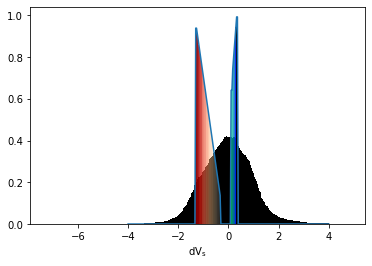

Ready to build scene


In [2]:
# setting up transfer functions 
tfOb = TFs.dv(data[datafld].ravel(),bounds=[-4,4])

# segment 1, slow anomalies
bnds=[-1.3,-.3]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='OrRd_r')
alpha_o=0.95
Dalpha=-0.85
alpha=alpha_o + Dalpha/(bnds[1]-bnds[0]) * (TFseg.dvbins_c-bnds[0])
tfOb.addTFsegment(alpha,TFseg)

# segment 2, fast anomalies
bnds=[.1,.35]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='winter_r')
alpha_o=.6
Dalpha=.4
alpha=alpha_o+ Dalpha/(bnds[1]-bnds[0]) * (TFseg.dvbins_c-bnds[0])
tfOb.addTFsegment(alpha,TFseg)
    
SH.plotTf(tfOb)
print("Ready to build scene")

In [6]:
sc = SH.configure_scene(ds, datafld, model, bbox, tfOb.tf,res_factor=1.25)

/home/chavlin/miniconda3/envs/yt_dev/lib/python3.7/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Scene ready to render


yt : [INFO     ] 2020-11-18 12:45:32,123 Rendering scene (Can take a while).
yt : [INFO     ] 2020-11-18 12:45:32,268 Creating volume
/home/chavlin/miniconda3/envs/yt_dev/lib/python3.7/site-packages/unyt/array.py:1649: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


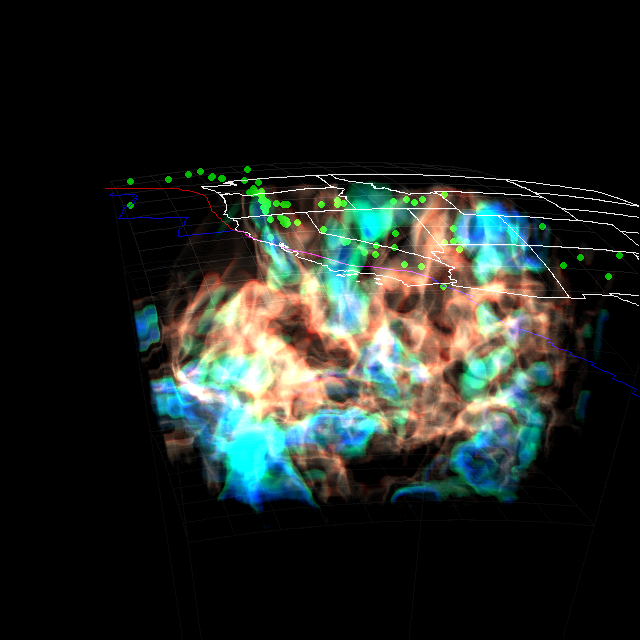

In [7]:
sc.show(sigma_clip=1.5)

In [10]:
sc.save('./figures/seismic_render.png', sigma_clip = 1.5, render=False)

yt : [INFO     ] 2020-11-18 15:14:11,754 Found previously rendered image to save.
yt : [INFO     ] 2020-11-18 15:14:11,757 Saving rendered image to ./figures/seismic_render.png


### Fixed Depth Maps


In [1]:
import numpy as np
import yt 
import os
import re
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4 as nc4

def get_data_path(arg):
    if os.path.exists(arg):
        return arg
    else:
        return os.path.join(yt.config.ytcfg.get("yt", "test_data_dir"), arg)

In [2]:
w_regex = re.compile(r'([a-zA-Z]+)(.*)')
def regex_parser(s):
    try:
        return "**".join(filter(None, w_regex.search(s).groups()))
    except AttributeError:
        return s

def get_dims(n):
    dims = []
    sizes = []
    bbox = []
    ndims = len(n.dimensions)
    for dim in n.dimensions.keys():
        size = n.variables[dim].size
        if size > 1:
            bbox.append([n.variables[dim][:].min(),
                         n.variables[dim][:].max()])
            dims.append(n.variables[dim].name)
            sizes.append(size)
   
    bbox = np.array(bbox)
    return dims, bbox, sizes, ndims
    
def prep_netcdf(n):
    
    dims, bbox, sizes, ndims = get_dims(n)
    
    data = {}
    names = {}
    for field, d in n.variables.items():
        if d.ndim != ndims:
            continue
        units = n.variables[field].units
        units =  " * ".join(map(regex_parser, units.split())) 
        data[field] = (np.squeeze(d), str(units))
        names[field] = n.variables[field].long_name.replace("_", " ")
        
    return bbox, data, names, dims, sizes

In [37]:
fi = "GYPSUM_percent.nc" 
n = nc4.Dataset(get_data_path(fi))
bbox, data, names, dims, sizes = prep_netcdf(n)

/home/chris/miniconda3/envs/yt_dev/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/chris/miniconda3/envs/yt_dev/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


In [38]:
# bbox[]
bbox[1][0]=-89.9
bbox[1][1]=89.9
bbox[2][0]=-189.9
bbox[2][1]=189.9
ds = yt.load_uniform_grid(data, sizes, 1.0, geometry=("internal_geographic", dims),bbox=bbox)

yt : [INFO     ] 2020-11-18 17:29:20,547 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-18 17:29:20,547 Parameters: domain_dimensions         = [100 181 361]
yt : [INFO     ] 2020-11-18 17:29:20,548 Parameters: domain_left_edge          = [   0.          -89.90000153 -189.8999939 ]
yt : [INFO     ] 2020-11-18 17:29:20,548 Parameters: domain_right_edge         = [ 2900.            89.90000153   189.8999939 ]
yt : [INFO     ] 2020-11-18 17:29:20,549 Parameters: cosmological_simulation   = 0.0


In [20]:
target_depth = 100
center = ds.domain_center

p = yt.SlicePlot(ds,"depth",'dvs',center=[target_depth,center[1],center[2]]) # will be domain center
p.set_cmap('dvs', 'dusk_r')
p.set_zlim('dvs', -10, 10)
p.set_log('dvs', False)

p.annotate_title(f"Depth={target_depth} km")

p.set_mpl_projection(('PlateCarree', (), {'central_longitude':center[2]}))#{'central_longitude':-100, 'central_latitude':40}))
p._setup_plots()

p.plots['dvs'].axes.coastlines()

yt : [INFO     ] 2020-11-18 17:22:29,623 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2020-11-18 17:22:29,630 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:22:29,631 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:22:29,634 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:22:29,635 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:22:29,638 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2020-11-18 17:22:29,731 Plot image for field ('stream', 'dvs') has both positive and negative values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2020-11-18 17:22:29,732 Switching to symlog colorbar scaling unless linear scaling is specified later



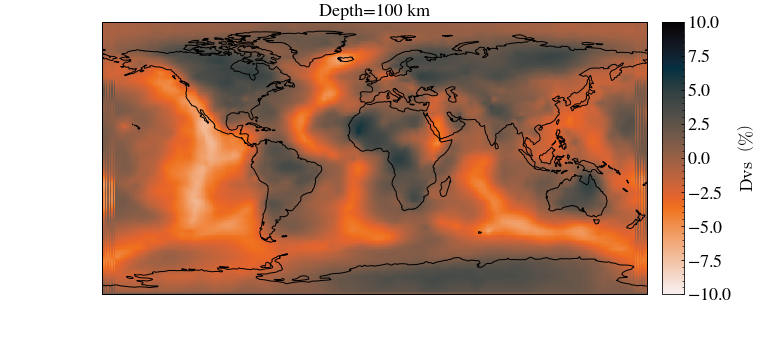

In [21]:
p.show()

In [22]:
p = yt.SlicePlot(ds,"depth",'dvs',center=[target_depth,center[1],center[2]]) # will be domain center
p.set_cmap('dvs', 'dusk_r')
p.set_zlim('dvs', -10, 10)
p.set_log('dvs', False)

p.annotate_title(f"Depth={target_depth} km")

p.set_mpl_projection(('Mollweide', (), {'central_longitude':center[2]}))#{'central_longitude':-100, 'central_latitude':40}))
p._setup_plots()

p.plots['dvs'].axes.coastlines()

yt : [INFO     ] 2020-11-18 17:22:36,379 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2020-11-18 17:22:36,386 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:22:36,387 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:22:36,390 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:22:36,391 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:22:36,394 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2020-11-18 17:22:36,460 Plot image for field ('stream', 'dvs') has both positive and negative values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2020-11-18 17:22:36,461 Switching to symlog colorbar scaling unless linear scaling is specified later



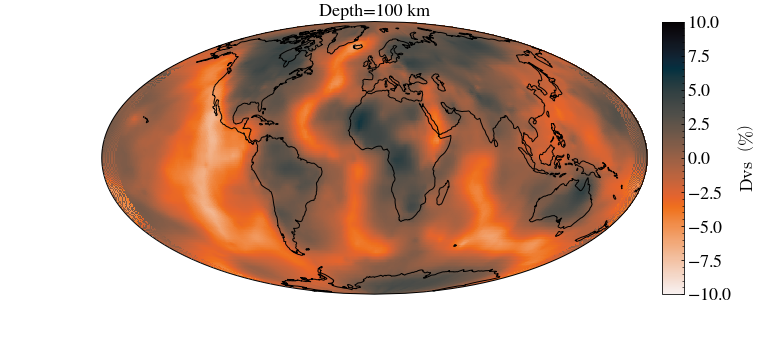

In [23]:
p.show()

In [11]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client = Client("IRIS")
starttime = UTCDateTime("2019-06-01")
endtime = UTCDateTime("2020-11-01")
cat = client.get_events(starttime=starttime, endtime=endtime,minmagnitude=5)

In [12]:
lat_lon_dep = [[ev.origins[0].latitude,ev.origins[0].longitude,ev.origins[0].depth] for ev in cat.events]
lat_lon_dep = np.array(lat_lon_dep)
lat_lon_dep.shape

(2226, 3)

yt : [INFO     ] 2020-11-18 17:22:43,234 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2020-11-18 17:22:43,240 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:22:43,241 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:22:43,244 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:22:43,245 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:22:43,249 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2020-11-18 17:22:43,323 Plot image for field ('stream', 'dvs') has both positive and negative values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2020-11-18 17:22:43,324 Switching to symlog colorbar scaling unless linear scaling is specified later



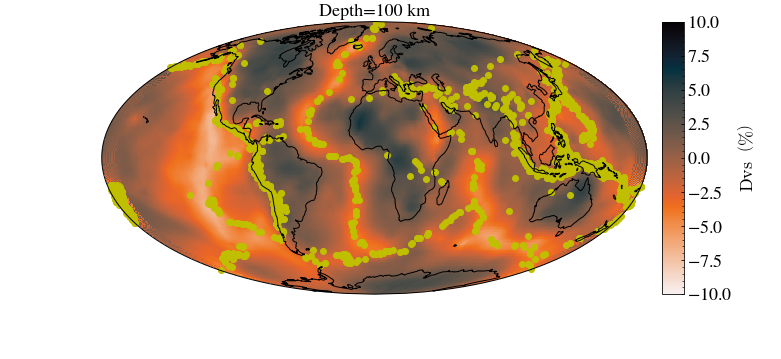

In [24]:
p = yt.SlicePlot(ds,"depth",'dvs',center=[target_depth,center[1],center[2]]) # will be domain center
p.set_cmap('dvs', 'dusk_r')
p.set_zlim('dvs', -10, 10)
p.set_log('dvs', False)

p.annotate_title(f"Depth={target_depth} km")


p.set_mpl_projection(('Mollweide', (), {'central_longitude':center[2]}))#{'central_longitude':-100, 'central_latitude':40}))
p._setup_plots()


p.plots['dvs'].axes.scatter(lat_lon_dep[:,1],lat_lon_dep[:,0],
           transform=ccrs.PlateCarree(),color='y')

p.plots['dvs'].axes.coastlines()
p.show()

In [25]:
from cartopy.io.shapereader import Reader

volc_file = get_data_path('harvard-glb-volc-shapefile/GLB_VOLC.shp')
volc_reader = Reader(volc_file)

yt : [INFO     ] 2020-11-18 17:29:26,251 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2020-11-18 17:29:26,421 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:29:26,422 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:29:26,424 xlim = -189.899994 189.899994
yt : [INFO     ] 2020-11-18 17:29:26,424 ylim = -89.900002 89.900002
yt : [INFO     ] 2020-11-18 17:29:26,426 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2020-11-18 17:29:26,471 Plot image for field ('stream', 'dvs') has both positive and negative values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2020-11-18 17:29:26,471 Switching to symlog colorbar scaling unless linear scaling is specified later



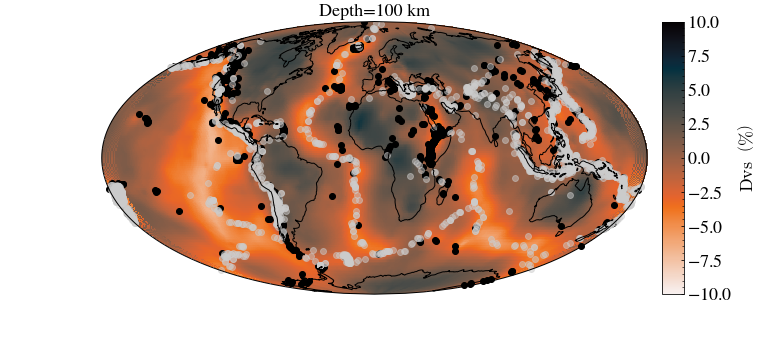

In [39]:
p = yt.SlicePlot(ds,"depth",'dvs',center=[target_depth,center[1],center[2]]) # will be domain center
p.set_cmap('dvs', 'dusk_r')
p.set_zlim('dvs', -10, 10)
p.set_log('dvs', False)

p.annotate_title(f"Depth={target_depth} km")


p.set_mpl_projection(('Mollweide', (), {'central_longitude':center[2]}))#{'central_longitude':-100, 'central_latitude':40}))
p._setup_plots()

points = list(volc_reader.geometries())
p.plots['dvs'].axes.scatter([point.x for point in points],
           [point.y for point in points],
           transform=ccrs.PlateCarree(),color='k')
    
p.plots['dvs'].axes.scatter(lat_lon_dep[:,1],lat_lon_dep[:,0],
           transform=ccrs.PlateCarree(),color=[.8,.8,.8,.5])

p.plots['dvs'].axes.coastlines()
p.show()

In [40]:
p.save('./figures/seismic_fixed_depth.png')

yt : [INFO     ] 2020-11-18 17:29:30,926 Saving plot ./figures/seismic_fixed_depth.png


['./figures/seismic_fixed_depth.png']